In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("dataset-1.csv") # importuję plik z danymi
df

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.
...,...,...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 19:00:00.000 +0200,Partly Cloudy,rain,26.016667,26.016667,0.43,10.9963,31.0,16.1000,0.0,1014.36,Partly cloudy starting in the morning.
96449,2016-09-09 20:00:00.000 +0200,Partly Cloudy,rain,24.583333,24.583333,0.48,10.0947,20.0,15.5526,0.0,1015.16,Partly cloudy starting in the morning.
96450,2016-09-09 21:00:00.000 +0200,Partly Cloudy,rain,22.038889,22.038889,0.56,8.9838,30.0,16.1000,0.0,1015.66,Partly cloudy starting in the morning.
96451,2016-09-09 22:00:00.000 +0200,Partly Cloudy,rain,21.522222,21.522222,0.60,10.5294,20.0,16.1000,0.0,1015.95,Partly cloudy starting in the morning.


In [3]:
df = df.copy()
# usuwam kolumny opisowe
df.drop(['Summary', 'Daily Summary','Loud Cover'], axis=1, inplace=True)

In [4]:
# Usuń temperature, gdzie humidity jest w przedziale 0.6–0.8 i windSpeed > 10
df.loc[(df['Humidity'] >= 0.6) & (df['Humidity'] <= 0.8) & (df['Wind Speed (km/h)'] > 10), 'Temperature (C)'] = np.nan

In [6]:
# Binaryzacja kolumny 'Precip Type' - zamiana na 1, jeśli 'rain', inaczej 0
df['Precip Type'] = df['Precip Type'].eq('rain').astype(int)

In [7]:
# inicjalizacja OneHotEncodera
one_hot_encoder = OneHotEncoder(sparse_output=False) # wynik kodowania będzie tablicą NumPy
recind_one_hot = one_hot_encoder.fit_transform(df["Precip Type"].to_numpy().reshape((-1, 1))) # przekształcenie kolumny RecInd na zakodowaną formę 
recind_one_hot_df = pd.DataFrame(recind_one_hot, columns=one_hot_encoder.get_feature_names_out(["Precip Type"])) # Tnowy dataframe z zakodowanymi danymi 

In [8]:
# połączenie zbiorów danych
df = df.reset_index(drop=True)
recind_one_hot_df = recind_one_hot_df.reset_index(drop=True)
df = pd.concat([df, recind_one_hot_df], axis=1) # łączenie zakodowanych danych z pozostałymi
df.drop(columns=["Precip Type"], axis=1, inplace=True) # usuwam kolumnę, która została zakodowana 

In [9]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], errors='coerce', utc=True).dt.tz_localize(None)

In [10]:
df

,Formatted Date,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Precip Type_0,Precip Type_1
0,2006-03-31 22:00:00,9.472222,7.388889,0.89,14.1197,251.0,15.8263,1015.13,0.0,1.0
1,2006-03-31 23:00:00,9.355556,7.227778,0.86,14.2646,259.0,15.8263,1015.63,0.0,1.0
2,2006-04-01 00:00:00,9.377778,9.377778,0.89,3.9284,204.0,14.9569,1015.94,0.0,1.0
3,2006-04-01 01:00:00,8.288889,5.944444,0.83,14.1036,269.0,15.8263,1016.41,0.0,1.0
4,2006-04-01 02:00:00,8.755556,6.977778,0.83,11.0446,259.0,15.8263,1016.51,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
96448,2016-09-09 17:00:00,26.016667,26.016667,0.43,10.9963,31.0,16.1000,1014.36,0.0,1.0
96449,2016-09-09 18:00:00,24.583333,24.583333,0.48,10.0947,20.0,15.5526,1015.16,0.0,1.0
96450,2016-09-09 19:00:00,22.038889,22.038889,0.56,8.9838,30.0,16.1000,1015.66,0.0,1.0
96451,2016-09-09 20:00:00,NaN,21.522222,0.60,10.5294,20.0,16.1000,1015.95,0.0,1.0


In [11]:
df['Day'] = df['Formatted Date'].dt.day
df['Month'] = df['Formatted Date'].dt.month
df['Year'] = df['Formatted Date'].dt.year
df['Hour'] = df['Formatted Date'].dt.hour
df.drop('Formatted Date', axis=1, inplace=True)

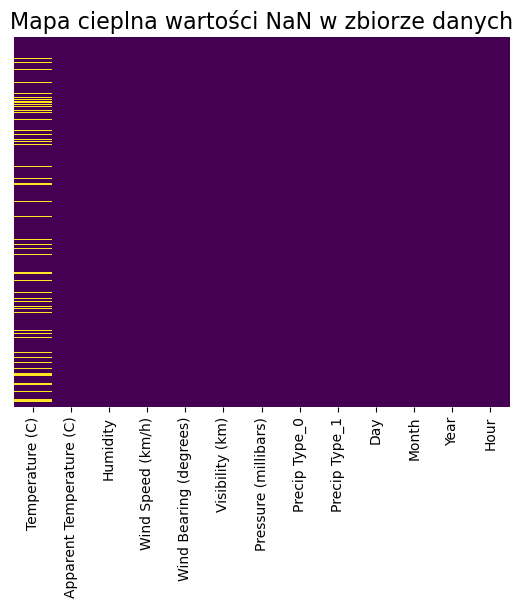

In [12]:
# w celu lepszego zobrazowania brakujących wartości tworzę mapę cieplną wartości NaN
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Mapa cieplna wartości NaN w zbiorze danych", fontsize=16)
plt.show()

In [13]:
y=df['Visibility (km)']
x=df.drop('Visibility (km)',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=42,shuffle=True)

In [14]:
# Imputacja braków metodą wypełniania zerami
imp_zero = SimpleImputer(strategy='constant', fill_value=0)
x_train_imputed = imp_zero.fit_transform(x_train)
x_test_imputed = imp_zero.transform(x_test)

In [15]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [16]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}


In [17]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 13.30
MAE: 2.98
RMSE: 3.65
R²: 0.24
------------------------------
Model: Decision Tree
MSE: 8.74
MAE: 1.66
RMSE: 2.96
R²: 0.50
------------------------------
Model: Random Forest
MSE: 4.27
MAE: 1.35
RMSE: 2.07
R²: 0.76
------------------------------
Model: Gradient Boosting
MSE: 6.23
MAE: 1.82
RMSE: 2.50
R²: 0.64
------------------------------


In [18]:
# Imputacja braków metodą wypełniania medianą
imp_median = SimpleImputer(strategy='median')
x_train_imputed = imp_median.fit_transform(x_train)
x_test_imputed = imp_median.transform(x_test)

In [19]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [20]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 13.25
MAE: 2.96
RMSE: 3.64
R²: 0.24
------------------------------
Model: Decision Tree
MSE: 8.59
MAE: 1.65
RMSE: 2.93
R²: 0.51
------------------------------
Model: Random Forest
MSE: 4.27
MAE: 1.34
RMSE: 2.07
R²: 0.76
------------------------------
Model: Gradient Boosting
MSE: 6.18
MAE: 1.81
RMSE: 2.49
R²: 0.65
------------------------------


In [21]:
def multiple_imputation_mice(train, test, num_imputations=3):
    train_imputed_datasets = []
    test_imputed_datasets = []

    for i in range(num_imputations):
        
        mice_imputer = IterativeImputer(random_state=i, max_iter=10, sample_posterior=True)

        # Imputacja dla zbioru treningowego
        imputed_train = pd.DataFrame(mice_imputer.fit_transform(train), columns=train.columns)
        train_imputed_datasets.append(imputed_train)

        # Imputacja dla zbioru testowego
        imputed_test = pd.DataFrame(mice_imputer.transform(test), columns=test.columns)
        test_imputed_datasets.append(imputed_test)

    # średnia wyników imputacji
    aggregated_train = pd.concat(train_imputed_datasets).groupby(level=0).mean()
    aggregated_test = pd.concat(test_imputed_datasets).groupby(level=0).mean()

    return aggregated_train, aggregated_test


aggregated_train, aggregated_test = multiple_imputation_mice(x_train, x_test, num_imputations=3)

# skalowanie danych
scaler = StandardScaler()
scaler.fit(aggregated_train)

# przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
aggregated_train_scaled = pd.DataFrame(scaler.transform(aggregated_train), columns=aggregated_train.columns, index=aggregated_train.index)
aggregated_test_scaled = pd.DataFrame(scaler.transform(aggregated_test), columns=aggregated_test.columns, index=aggregated_test.index)

# iteracja po każdym modelu
for name, model in models.items():
    # Trenowanie modelu na przetworzonych danych treningowych
    model.fit(aggregated_train_scaled, y_train)
    
    # Predykcja na przetworzonym zbiorze testowym
    y_pred = model.predict(aggregated_test_scaled)
    
    # Obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print(f"MSE: {mse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")
    print("-" * 30)


Model: Linear Regression
MSE: 13.42
MAE: 2.98
RMSE: 3.66
R²: 0.23
------------------------------
Model: Decision Tree
MSE: 8.65
MAE: 1.65
RMSE: 2.94
R²: 0.51
------------------------------
Model: Random Forest
MSE: 4.26
MAE: 1.35
RMSE: 2.07
R²: 0.76
------------------------------
Model: Gradient Boosting
MSE: 6.18
MAE: 1.81
RMSE: 2.49
R²: 0.65
------------------------------


In [22]:
# Imputacja braków metodą wypełniania knn
imp_knn = KNNImputer(n_neighbors=3)
x_train_imputed = imp_knn.fit_transform(x_train)
x_test_imputed = imp_knn.transform(x_test)

In [23]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [24]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 13.40
MAE: 2.98
RMSE: 3.66
R²: 0.24
------------------------------
Model: Decision Tree
MSE: 8.56
MAE: 1.64
RMSE: 2.93
R²: 0.51
------------------------------
Model: Random Forest
MSE: 4.27
MAE: 1.35
RMSE: 2.07
R²: 0.76
------------------------------
Model: Gradient Boosting
MSE: 6.22
MAE: 1.82
RMSE: 2.49
R²: 0.65
------------------------------


In [25]:
# Funkcja imputacji LightGBM
def lightgbm_imputation_train_test(x_train, x_test):
    x_train = x_train.copy()
    x_test = x_test.copy()
    
    for column in x_train.columns:
        missing_train = x_train[column].isnull()
        missing_test = x_test[column].isnull()
        
        if missing_train.any() or missing_test.any():
            # Przygotowanie danych do modelu
            x_train_features = x_train.loc[~missing_train].drop(columns=column)
            y_train = x_train.loc[~missing_train, column]
            
            x_test_features = x_test.drop(columns=column)
            
            # LightGBM - imputacja na zbiorze treningowym
            model = LGBMRegressor(random_state=42)
            model.fit(x_train_features, y_train)
            
            # Imputacja braków w zbiorze treningowym
            if missing_train.any():
                x_train.loc[missing_train, column] = model.predict(x_train.loc[missing_train].drop(columns=column))
            
            # Imputacja braków w zbiorze testowym
            if missing_test.any():
                x_test.loc[missing_test, column] = model.predict(x_test_features.loc[missing_test])
    
    return x_train, x_test


x_train_imputed, x_test_imputed = lightgbm_imputation_train_test(x_train, x_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003745 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 55821, number of used features: 11
[LightGBM] [Info] Start training from score 12.219295


In [26]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [27]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 13.41
MAE: 2.98
RMSE: 3.66
R²: 0.24
------------------------------
Model: Decision Tree
MSE: 8.46
MAE: 1.63
RMSE: 2.91
R²: 0.52
------------------------------
Model: Random Forest
MSE: 4.28
MAE: 1.35
RMSE: 2.07
R²: 0.76
------------------------------
Model: Gradient Boosting
MSE: 6.20
MAE: 1.81
RMSE: 2.49
R²: 0.65
------------------------------


In [225]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(final_train)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
final_train = pd.DataFrame(scaler.transform(final_train), columns=x_train.columns, index=x_train.index)
final_test = pd.DataFrame(scaler.transform(final_test), columns=x_test.columns, index=x_test.index)

In [226]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 13.72
MAE: 2.99
RMSE: 3.70
R²: 0.22
------------------------------
Model: Decision Tree
MSE: 8.64
MAE: 1.65
RMSE: 2.94
R²: 0.51
------------------------------
Model: Random Forest
MSE: 9.57
MAE: 2.21
RMSE: 3.09
R²: 0.45
------------------------------
Model: Gradient Boosting
MSE: 6.33
MAE: 1.84
RMSE: 2.52
R²: 0.64
------------------------------


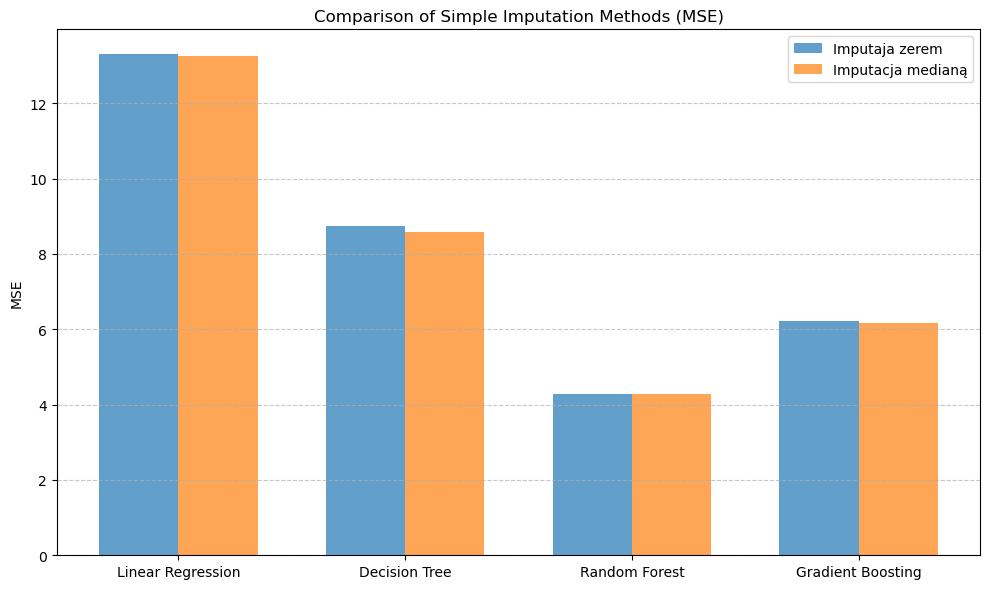

In [28]:
import matplotlib.pyplot as plt
import numpy as np
methods = ['Imputation Zero', 'Imputation Median']
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
mse_zero = [13.30, 8.74, 4.27, 6.23]
mse_median = [13.25, 8.59, 4.27, 6.18]
x = np.arange(len(models))
width = 0.35 
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mse_zero, width, label='Imputaja zerem', alpha=0.7)
plt.bar(x + width/2, mse_median, width, label='Imputacja medianą', alpha=0.7)
plt.ylabel('MSE')
plt.title('Comparison of Simple Imputation Methods (MSE)')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

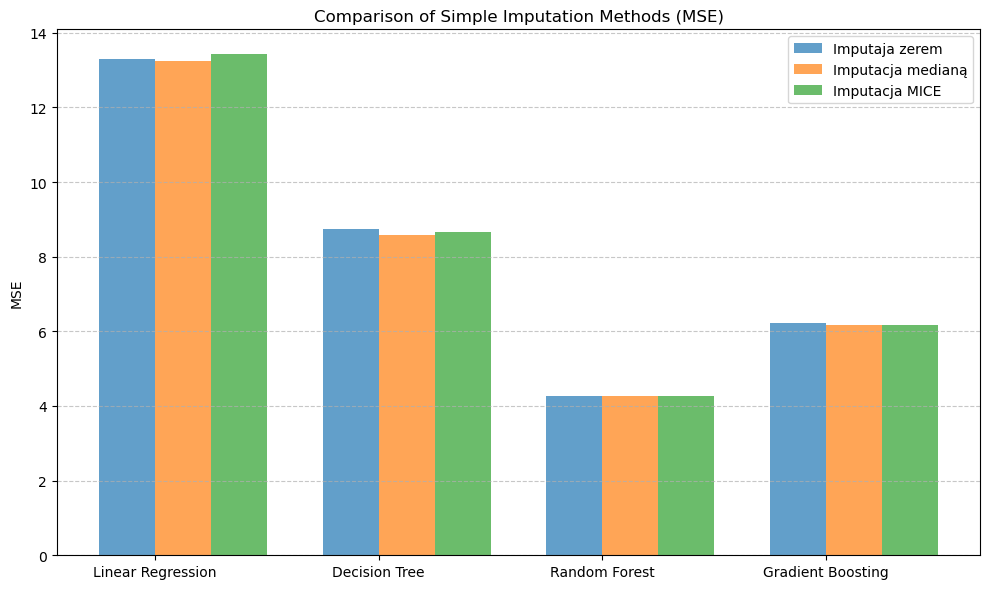

In [29]:
import matplotlib.pyplot as plt
import numpy as np
methods = ['Imputation Zero', 'Imputation Median']
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
mse_zero = [13.30, 8.74, 4.27, 6.23]
mse_median = [13.25, 8.59, 4.27, 6.18]
mse_mice = [13.42, 8.65, 4.26, 6.18]
x = np.arange(len(models)) 
width = 0.25  
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mse_zero, width, label='Imputaja zerem', alpha=0.7)
plt.bar(x + width/2, mse_median, width, label='Imputacja medianą', alpha=0.7)
plt.bar(x + width*1.5, mse_mice, width, label='Imputacja MICE', alpha=0.7)
plt.ylabel('MSE')
plt.title('Comparison of Simple Imputation Methods (MSE)')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
data = {
    "method": [
        "zero", "zero", "zero", "zero",
        "mediana", "mediana", "mediana", "mediana",
        "MICE", "MICE", "MICE", "MICE",
        "KNN", "KNN", "KNN", "KNN",
        "LightGBM", "LightGBM", "LightGBM", "LightGBM"
    ],
    "model": [
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB"
    ],
    "R2": [
        0.24, 0.50, 0.76, 0.64,
        0.24, 0.51, 0.76, 0.65,
        0.23, 0.51, 0.76, 0.65,
        0.24, 0.51, 0.76, 0.65,
        0.24, 0.52, 0.76, 0.65
    ],
    "MSE": [
        13.30, 8.74, 4.27, 6.23,
        13.25, 8.59, 4.27, 6.18,
        13.42, 8.65, 4.26, 6.18,
        13.40, 8.56, 4.27, 6.22,
        13.41, 8.46, 4.28, 6.20
    ]
}

df = pd.DataFrame(data)
print(df)

      method model    R2    MSE
0       zero    LR  0.24  13.30
1       zero    DT  0.50   8.74
2       zero    RF  0.76   4.27
3       zero    GB  0.64   6.23
4    mediana    LR  0.24  13.25
5    mediana    DT  0.51   8.59
6    mediana    RF  0.76   4.27
7    mediana    GB  0.65   6.18
8       MICE    LR  0.23  13.42
9       MICE    DT  0.51   8.65
10      MICE    RF  0.76   4.26
11      MICE    GB  0.65   6.18
12       KNN    LR  0.24  13.40
13       KNN    DT  0.51   8.56
14       KNN    RF  0.76   4.27
15       KNN    GB  0.65   6.22
16  LightGBM    LR  0.24  13.41
17  LightGBM    DT  0.52   8.46
18  LightGBM    RF  0.76   4.28
19  LightGBM    GB  0.65   6.20


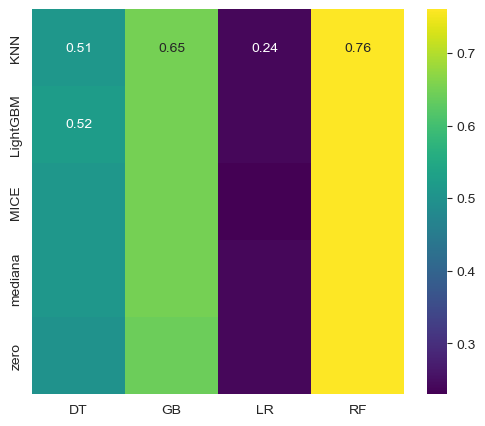

In [35]:
df_pivot_r2 = df.pivot(index="method", columns="model", values="R2")
plt.figure(figsize=(6, 5))
sns.heatmap(df_pivot_r2, annot=True, cmap="viridis", fmt=".2f")
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.show()

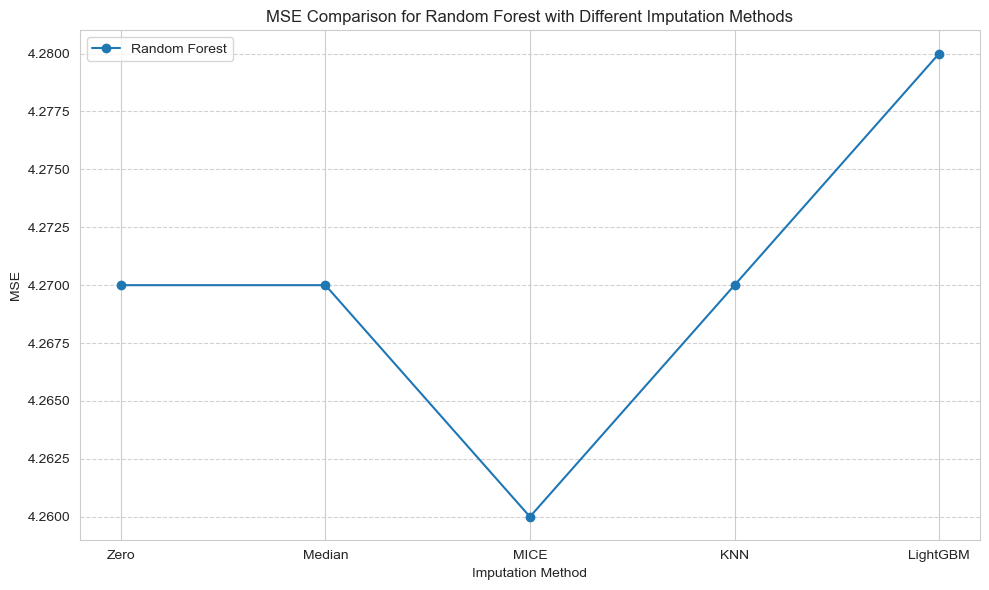

In [3]:
mse_methods = [4.27, 4.27, 4.26, 4.27, 4.28]
methods = ['Zero', 'Median', 'MICE', 'KNN', 'LightGBM']
plt.figure(figsize=(10, 6))
plt.plot(methods, mse_methods, marker='o', linestyle='-', label='Random Forest')
plt.ylabel('MSE')
plt.xlabel('Imputation Method')
plt.title('MSE Comparison for Random Forest with Different Imputation Methods')
plt.grid(axis='y', linestyle='--', alpha=0.9)
plt.legend()
plt.tight_layout()
plt.show()